Google Colab - Assignment 3B - 2021

> Indented block



# Set-up
Before running any of the cells use GPU accelerator by going to **Runtime** -> **Change runtype type** -> Select **GPU** for the hardware accelerator

Only do this when you plan to run training as if you leave it idle for too long you may run out of resources.

## Download Files

Run the following cells to download the required data to complete the assignment.




In [ ]:
#Follow the instructions displayed in the output
import io
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from zipfile import ZipFile

#File downloader
def zip_downloader(file_id):
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
  #Extract zip file
  with ZipFile(downloaded) as zipf:
      zipf.extractall()

#Authorize user  
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [ ]:
#Download  files
zip_downloader("1oXbRYy7_GRetrv1U-kCLgXQo_OgVSIK3") #annotations
zip_downloader("1CZYJI2KJWZnLy7B62LUX3cAYpyn9TLEL") #images

##Install Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="400">

Detectron2 is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. We will employ some some basics features of detectron2, including the following:
* Run inference on images with an existing detectron2 model
* Train a detectron2 model on a new dataset

This is built off of pytorch, which is a open source machine learning framework similar to Keras.

Reference the [documentation](https://detectron2.readthedocs.io/en/latest/) for detailed docmentation of dectctron2 usage.


Adapted from this [colab tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=PIbAM2pv-urF).

In [ ]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
#Install MTCNN Network
!pip install mtcnn
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=15ca7e45af74d74042d1a553273d5808891946ae7c89e5a73c74ef3ae311a924
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 1.0 MB/s 
     |████████████████████████████████| 147 kB 5.3 MB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 74 kB 2.8 MB/s 
     |████████████████████████████████| 130 kB 44.6 MB/s 
     |████████████████████████████████| 749 kB 49.5 MB/s 
     |████████████████████████████████

     |████████████████████████████████| 2.3 MB 5.3 MB/s 


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random,copy
from google.colab.patches import cv2_imshow

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper,build_detection_train_loader,build_detection_test_loader, MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

#Load MTCNN network
from mtcnn.mtcnn import MTCNN

## Load Dataset

We are going use the dectron2 dataloader functions to load our annotations (the ones you completed as part of assignment 3A). The annotations have been saved in COCO format. This is a common format to save annotations. 

There are 4 datasets:

1. `dataset_face`: this contains only face annotations
2. `dataset_face_1`: this is a second set of face annotations for the same images (different annotators)
3. `dataset_head`: this contains only head annotations
4. `dataset_head_1`: this is a second set of head annotations for the same images (different annotators)

The `dataset_*` variable contains a list of dicts with the following categories:

* `file_name`: the full path to the image file.

* `height`, `width`: integer. The shape of the image.

* `image_id` (str or int): a unique id that identifies this image. Required by many evaluators to identify the images, but a dataset may use it for different purposes.

* `annotations` (list[dict]): Required by instance detection/segmentation or keypoint detection tasks. Each dict corresponds to annotations of one instance in this image (in our case we only have one annotation per image):

  * `bbox` (list[float], required): list of 4 numbers representing the bounding box of the instance.

  * `category_id` (int, required): an integer in the range [0, num_categories-1] representing the category label.

In [ ]:
#Register the datasets; whenever we reference the datasets we will use the names defined here
register_coco_instances("dataset_face_train", {}, "annotations_train/instances_face_train.json","Neonate Face Dataset")
register_coco_instances("dataset_face_train_1", {}, "annotations_train/instances_face_train_1.json","Neonate Face Dataset")
register_coco_instances("dataset_head_train", {}, "annotations_train/instances_head_train.json","Neonate Face Dataset")
register_coco_instances("dataset_head_train_1", {}, "annotations_train/instances_head_train_1.json","Neonate Face Dataset")
register_coco_instances("dataset_face_val", {}, "annotations_train/instances_face_val.json","Neonate Face Dataset")
register_coco_instances("dataset_face_val_1", {}, "annotations_train/instances_face_val_1.json","Neonate Face Dataset")
register_coco_instances("dataset_head_val", {}, "annotations_train/instances_head_val.json","Neonate Face Dataset")
register_coco_instances("dataset_head_val_1", {}, "annotations_train/instances_head_val_1.json","Neonate Face Dataset")

In [ ]:
#Reorder duplicate annotations to match first
def reorder_data(dataset,dataset_1):
  original = [d['file_name'] for d in dataset]
  duplicates = [d['file_name'] for d in dataset_1]
  inds = [duplicates.index(f) for f in original]
  return list(np.array(dataset_1)[inds])
#Provide the dataset in a dictonary format 
dataset_face = DatasetCatalog.get("dataset_face_train") + DatasetCatalog.get("dataset_face_val")
dataset_face_1 = DatasetCatalog.get("dataset_face_train_1") + DatasetCatalog.get("dataset_face_val_1")
dataset_face_1 = reorder_data(dataset_face,dataset_face_1)
dataset_head = DatasetCatalog.get("dataset_head_train") + DatasetCatalog.get("dataset_head_val")
dataset_head_1 = DatasetCatalog.get("dataset_head_train_1") + DatasetCatalog.get("dataset_head_val_1")
dataset_head_1 = reorder_data(dataset_head,dataset_head_1)
metadata_face = MetadataCatalog.get("dataset_face_train")
metadata_head = MetadataCatalog.get("dataset_head_train")

[04/18 03:56:35 d2.data.datasets.coco]: Loaded 711 images in COCO format from annotations_train/instances_face_train.json
[04/18 03:56:35 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_face_val.json
[04/18 03:56:35 d2.data.datasets.coco]: Loaded 711 images in COCO format from annotations_train/instances_face_train_1.json
[04/18 03:56:35 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_face_val_1.json
WARNING [04/18 03:56:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/18 03:56:36 d2.data.datasets.coco]: Loaded 711 images in COCO format from annotations_train/instances_head_train.json
WARNING [04/18 03:56:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/18 03:56:36 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_head_val

## Visualize Data

We are going to use the dectron2 visualizer functions to visualize the bounding boxes. The cell below shows an example of how to use this function on the ground truth annotations. When we load images using `cv2.imread` the image loads in BRG. We must reverse the order of the colour channels from BRG to RGB to load it into the `Visualizer` function. We then reverse it again to properly display it in `cv2_imshow`. To reverse the order of colour channels we can slice the image using `[:, :, ::-1]`

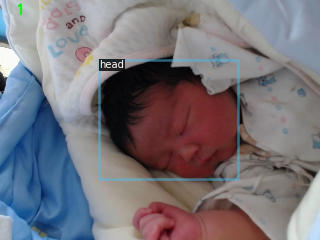

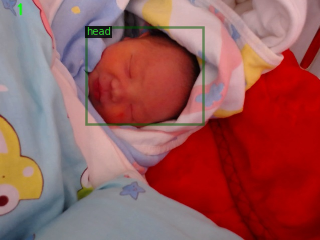

In [ ]:
for d in np.array(dataset_head)[329:331]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_head,scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Assignment Questions


## Q1) Annotator Agreement (4)

With any labelling task there is some variation that comes from differences between annotators. The degree of agreement among independent observers is called inter-rater reliability. 

For our training data each image was labelled by two independent annotators. One set of annotations is stored in `dataset_{face}/{head}` and its pair of annotations is stored in `dataset_{face}/{head}_1`. We would like to measure the inter-rater reliability for our dataset for both the face and head annotations. This is possible by calculating the IoU between the two annotations for each image.

**Questions:**
1. Calculate the average IoU across all the images for both face and head annotations
2. Plot a histogram showing the distribution of IoU scores for both face and head annotations
3. Using the visualizing function, plot an example of an image with annotations that have an IoU less than 0.7 for both face and head annotations
4. **Discussion**: Between the face and head annotations, which type has a lower inter-rater reliability? Give an example of one factor that may lead to poor inter-rater reliability in the context of image annotation.

**NOTE**

* Use the provided function to calculate IoU; it takes two parameters, one for each bbox list  
* To access the annotations from the dataset: `dataset_{face}/{head}['annotations'][#][0]['bbox']`
* You should compare the annotations from `dataset_{face}/{head}` and `dataset_{face}/{head}_1` directly; the order of the images are the same 
* Warning: Some images may not have annotations, in this case the corresponding `annotation` field will be an empty list; you need to implement a check to make sure an annotation exists in both `dataset_{face}/{head}` and `dataset_{face}/{head}_1`




In [ ]:
def IoU(a, b):  
  dx = min(a[0]+a[2], b[0]+b[2]) - max(a[0], b[0])
  dy = min(a[1]+a[3], b[1]+b[3]) - max(a[1], b[1])
  if (dx>=0) and (dy>=0):
    interArea = dx*dy
  else:
    interArea = 0
  boxAArea = a[2]*a[3]
  boxBArea = b[2]*b[3]
  return interArea / (boxAArea + boxBArea - interArea)

The average IoU across all face images is:  0.7068293490856281
The average IoU across all head images is:  0.8960162490043285


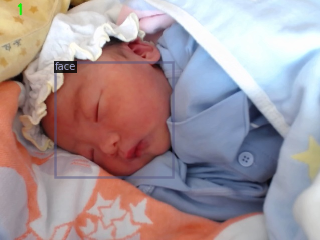

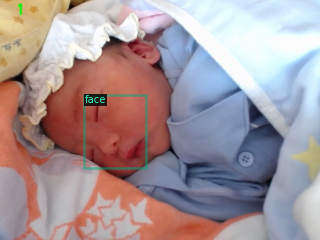

The  782  index of the face data has a minimum IoU of  0.3293561884562639


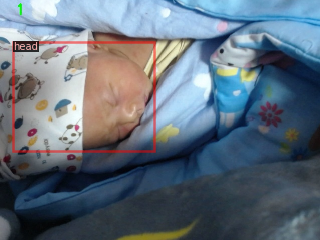

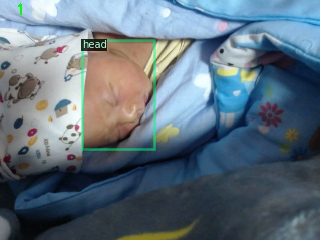

The  406  index of the head data has a minimum IoU of  0.4996468428710315


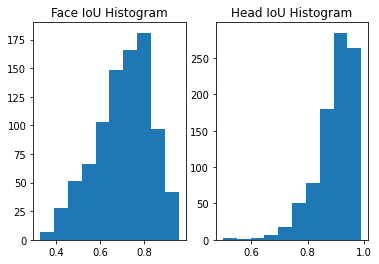

In [ ]:
#Solution here:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calc_avg(arr): #Calculate mean given an array of values
  arrSum = 0
  for x in arr:
    arrSum += x
  return arrSum/len(arr)

#Create dataframes
face_0_df = pd.DataFrame(dataset_face)
face_1_df = pd.DataFrame(dataset_face_1)
head_0_df = pd.DataFrame(dataset_head)
head_1_df = pd.DataFrame(dataset_head_1)

#Set up to create dicts to look at 5 lowest IoU examples
lowFaceKey = np.zeros((5,), dtype=int) #Zeros array size of 5
lowFaceValue = np.zeros((5,), dtype=float)
lowHeadKey = np.zeros((5,), dtype=int)
lowHeadValue = np.zeros((5,), dtype=float)
minFaceIoU = 1 #Highest possible IoU, can only be lower than this value
minHeadIoU = 1
maxFaceIoU = 0
maxHeadIoU = 0
highFaceKey = 0
highHeadKey = 0

face_iou = np.zeros(face_0_df['annotations'].size) #Empty arrays to store all IoU values
head_iou = np.zeros(head_0_df['annotations'].size)
for i in range(face_0_df['annotations'].size):
  face_iou[i] = IoU(face_0_df['annotations'][i][0]['bbox'],face_1_df['annotations'][i][0]['bbox']) #Calculate IoU using given function
  head_iou[i] = IoU(head_0_df['annotations'][i][0]['bbox'],head_1_df['annotations'][i][0]['bbox'])
  if (face_iou[i] > maxFaceIoU):
    highFaceKey = i
  if (head_iou[i] > maxHeadIoU):
    highHeadKey = i
  if (face_iou[i] < minFaceIoU): #If lower than minimum IoU, store value as key/value pair in dict, if value exists in lowest slot, roll ndarray and store in new lowest slot.
    if (lowFaceKey[0] == 0): #If storing element where key is still initial value of 0, store key/value pair in respective arrays
      lowFaceKey[0] = i
      lowFaceValue[0] = face_iou[i]
      minFaceIoU = face_iou[i] #Set new minimum
    elif (lowFaceKey[0] != 0): #If value already exists in key, roll key by 1 index, store key/value pair in respective arrays
      lowFaceKey = np.roll(lowFaceKey,1) 
      lowFaceValue = np.roll(lowFaceValue,1)
      lowFaceKey[0] = i
      lowFaceValue[0] = face_iou[i]
      minFaceIoU = face_iou[i] #Set new minimum
  if (head_iou[i] < minHeadIoU):
    if (lowHeadKey[0] == 0):
      lowHeadKey[0] = i
      lowHeadValue[0] = head_iou[i]
      minHeadIoU = head_iou[i]
    elif (lowHeadKey[0] != 0):
      lowHeadKey = np.roll(lowHeadKey,1)
      lowHeadValue = np.roll(lowHeadValue,1)
      lowHeadKey[0] = i
      lowHeadValue[0] = head_iou[i]
      minHeadIoU = head_iou[i]
print("The average IoU across all face images is: ", calc_avg(face_iou)) #Print results of average IoU
print("The average IoU across all head images is: ", calc_avg(head_iou))

lowFaceIoUDict = dict(zip(lowFaceKey, lowFaceValue))
lowHeadIoUDict = dict(zip(lowHeadKey, lowHeadValue))

img = cv2.imread(face_0_df['file_name'][list(lowFaceIoUDict.keys())[0]]) #Select 0th index of minimum face IoU as file to imread to cv2
visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_face,scale=0.5) #Reverse BRG, set tag as face
out = visualizer.draw_dataset_dict(face_0_df.iloc[list(lowFaceIoUDict.keys())[0]]) #Feed pandas dataframe row to visualizer function with key from dict
cv2_imshow(out.get_image()[:, :, ::-1]) #Re-reverse BRG to normal
img = cv2.imread(face_1_df['file_name'][list(lowFaceIoUDict.keys())[0]]) #Redo the same with the other set of annotations to compare
visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_face,scale=0.5)
out = visualizer.draw_dataset_dict(face_1_df.iloc[list(lowFaceIoUDict.keys())[0]])
cv2_imshow(out.get_image()[:, :, ::-1])
print("The ", list(lowFaceIoUDict.keys())[0], " index of the face data has a minimum IoU of ", list(lowFaceIoUDict.values())[0])

img = cv2.imread(head_0_df['file_name'][list(lowHeadIoUDict.keys())[0]]) #Select 0th index of minimum head IoU as file to imread to cv2
visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_head,scale=0.5) #Reverse BRG, set tag as head
out = visualizer.draw_dataset_dict(head_0_df.iloc[list(lowHeadIoUDict.keys())[0]]) #Feed pandas dataframe row to visualizer function with key from dict
cv2_imshow(out.get_image()[:, :, ::-1]) #Re-reverse BRG to normal
img = cv2.imread(head_1_df['file_name'][list(lowHeadIoUDict.keys())[0]]) #Redo the same with the other set of annotations to compare
visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_head,scale=0.5)
out = visualizer.draw_dataset_dict(head_1_df.iloc[list(lowHeadIoUDict.keys())[0]])
cv2_imshow(out.get_image()[:, :, ::-1])
print("The ", list(lowHeadIoUDict.keys())[0], " index of the head data has a minimum IoU of ", list(lowHeadIoUDict.values())[0])


fig, (ax1, ax2) = plt.subplots(1, 2) #Create 10 bin histograms showing IoU of face and head as subplots
ax1.set_title("Face IoU Histogram")
ax1.hist(face_iou, 10);
ax2.set_title("Head IoU Histogram")
ax2.hist(head_iou, 10);


**Q1 Discusion here**

As seen from the results of the code, the average IoU for the head from the annotations performed much better than the average IoU for the face annotations. The face IoU histogram also seems to show that the face IoU values has a skewed normal distribution while the head IoU histogram shows that a large amount of the IoU values are above 0.85 or 0.9 which is much better than than the IoU values for faces. The minimum for the head IoU values is also only slightly below 0.5 at 0.499 while the minimum value for the face IoU values is 0.329. This shows that the head annotations has a much higher inter-rater reliability.

The visualizer function shows one example of a head where the IoU is a minimum value of 0.499 is shown along with a face where the IoU is a minimum value of 0.329.

The face example has a very low IoU as the annotation in the '0' dataset only has the bounding box across the minimum of the face and cuts off part of the ye while the annotation in '1' dataset has a much larger bounding box for the same image which includes large amounts of the face below the mouth and the forehead.

The head example has a very low IoU as the '0' dataset annotation attempts to predict where the full head would be under the hat leading to a much smaller bounding box compared to the '1' dataset where the bounding box is cut off at the hat. This means that the '0' dataset annotation is larger than the '1' dataset annotation in only 1 dimension and leads to a much higher IoU compared to the face example.

## Q2) Trying MTCNN (2)

We want to asses how well MTCNN (used in Assignment 2) performs on our dataset. 

**Questions:**
1. Test MTCNN on the `dataset_face_1` for the first 100 images and report the number of detections that were correctly made (IoU > 0.5). 
2. Why do you think the performance of MTCNN is poor on our dataset?

A code example is shown below illustrating how to use the MTCNN functions. Be sure to the reverse the order of the colour channels before predicting bounding boxes.




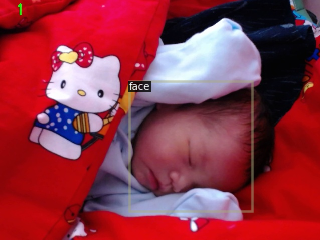

In [ ]:
mtcnn = MTCNN()
d = np.array(dataset_face_1)[0]
img = cv2.imread(d["file_name"])
faces = mtcnn.detect_faces(img[:, :, ::-1])
for f in faces:
  d['annotations'][0]['bbox'] = f['box']
  visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_face,scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#Solution here:
import matplotlib.pyplot as plt
detector = MTCNN();
count = 0 #Count of examples where IoU > 0.5
for i in range(100): #Only first 100 images
  filename = '/content/' + face_1_df['file_name'][0]
  img = cv2.imread(d['file_name'])
  faces = detector.detect_faces(img[:, :, ::-1]);
  for f in faces:
    count += IoU(face_1_df['annotations'][i][0]['bbox'],f['box']) > 0.5
print("The total number of faces detected by MTCNN in the 1 dataset is: ", count) #Display results

The total number of faces detected by MTCNN in the 1 dataset is:  9


**Q2 Disscussion here**
As shown by the output of the code segment above, the number of faces detected by the MTCNN algorithm in the '1' dataset only contains 9 examples where the IoU is greater than 0.5. This shows that MTCNN does a poor job of detecting faces. This could be because there are a large number of examples where the face is partially occluded or is not a front facing angle.

## Q3) Faster R-CNN (3)

Let's examine the Faster R-CNN architecture for our object detection task. This differs from MTCNN from the previous assignment in that it is fully differentiable (trainable end-to-end) and can make use of pre-trained models for feature extraction. 

<img src="https://tryolabs.imgix.net/assets/blog/2018-01-18-faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/fasterrcnn-architecture.png?auto=format&fit=max&w=3840" width="700">

Read this [article](https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection) about Faster R-CNN and answer the following **questions**.

1. How does the Faster R-CNN object detection framework solve "variable length" output problem?
2. What is the role of the base network?
3. What are the outputs of the RPN stage for Faster R-CNN and what is the total number of output channels?


**Q3 Disscussion here**

The "variable length" problem is solved by using anchors, which is a list of generated bounding boxes of various sizes and ratios which can be used as references. Each of these anchors is checked for a relevant object and can be adjusted to better fit the relevant object by adjusting the ratios and sizes of the anchors.

The base network is a pretrained CNN used for classification and returns the input for the region proposan network. This input is a convolutional feature map.

The output of the RPN stage for Faster R-CNN contains a tensor that is shaped by the number of classes. The total number of output channels depends is a 1x1 kernel with a total number of channels that depends on the number of anchors per point.

## Q4) Train! (2)

Now, let's train our own object detection model! We will start by training a head detection model. The code to train the model has already been provided, however you should adjust the various parameters and try to achieve the best performance you can.

The parameters you can adjust are:


1. `base_model`: this is the path of the pre-trained model that you will use. The list of models can be found [here](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md). Click on the link to model you want, click the three dots beside the github path and copy the path to the model. Paste this in the form without including the 'configs/' at the begininng of the path.
  *i.e. if you copied configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml only keep COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml*
2. `batch_size`: controls number of images per batch
3. `iterations`: number of training iterations to run
4. `learning_rate`: controls the learning rate
5. `learning_rate_decay`: list of iteration numbers where learning rate is to be reduced

**Discuss** your reasoning for your choice of base model.


In [ ]:
#@markdown Fill in this form with your parameters and run the cell.
base_model = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" #@param {type: "string"}
batch_size =  4#@param {type: "integer"}
iterations =  500#@param {type: "integer"}
learning_rate = 0.0002  #@param {type: "number"}
learning_rate_decay =   []#@param
cfg = get_cfg()

#Load pre-trained model
cfg.merge_from_file(model_zoo.get_config_file(base_model))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_model) 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 #set number of classes
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 

#Load training set and validation set
cfg.DATASETS.TRAIN = ("dataset_head_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

#Adjust Solver parameters
cfg.SOLVER.BASE_LR = learning_rate
cfg.SOLVER.MAX_ITER = iterations  
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.STEPS = learning_rate_decay    # do not decay learning rate

cfg.OUTPUT_DIR = 'output_head'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/18 03:58:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:03, 50.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[04/18 03:58:28 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/18 03:59:22 d2.utils.events]:  eta: 0:22:04  iter: 19  total_loss: 0.8741  loss_cls: 0.7007  loss_box_reg: 0.1571  loss_rpn_cls: 0.006157  loss_rpn_loc: 0.007224  time: 2.7129  data_time: 0.0485  lr: 7.7924e-06  max_mem: 6975M


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/18 04:00:16 d2.utils.events]:  eta: 0:21:27  iter: 39  total_loss: 0.7422  loss_cls: 0.5472  loss_box_reg: 0.1533  loss_rpn_cls: 0.008841  loss_rpn_loc: 0.008529  time: 2.7019  data_time: 0.0303  lr: 1.5784e-05  max_mem: 6975M
[04/18 04:01:09 d2.utils.events]:  eta: 0:20:13  iter: 59  total_loss: 0.5007  loss_cls: 0.3472  loss_box_reg: 0.1603  loss_rpn_cls: 0.006992  loss_rpn_loc: 0.006699  time: 2.6790  data_time: 0.0322  lr: 2.3776e-05  max_mem: 6975M
[04/18 04:02:04 d2.utils.events]:  eta: 0:19:32  iter: 79  total_loss: 0.4126  loss_cls: 0.2301  loss_box_reg: 0.1601  loss_rpn_cls: 0.007615  loss_rpn_loc: 0.008304  time: 2.6984  data_time: 0.0239  lr: 3.1768e-05  max_mem: 6975M
[04/18 04:02:57 d2.utils.events]:  eta: 0:18:31  iter: 99  total_loss: 0.3535  loss_cls: 0.1725  loss_box_reg: 0.1649  loss_rpn_cls: 0.005219  loss_rpn_loc: 0.007203  time: 2.6925  data_time: 0.0323  lr: 3.976e-05  max_mem: 6975M
[04/18 04:03:51 d2.utils.events]:  eta: 0:17:40  iter: 119  total_loss: 0.322

**Q4 Disscusion here**

As stated in the `README.md` for the model zoo, models that use the ResNet+FPN backbone with standard conv and FC heads has a much greater speed/accuracy tradeoff than the C4 or dilated-C5 backbone combinations. This narrows the choices for base model to the FPN models. The R-50 model was chosen over the R-101 and R-152 as the R-50 FPN model had better accuracy and loss metrics compared to the other models while using less memory which was a problem encountered during training. Finally, the model with 3x learning rate schedule was selected over the model with 1x learning rate schedule as the difference in training time, inference time and training memory are identical whilie box AP increases compared to the 1x model. It is likely that without the compute resource constraint, the R101-FPN model would have been chosen.

The remaining parameters were adjusted to decrease loss and increase accuracy. It was not possible to tune all parameters to the full extent as GPU usage and GPU memory issues were frequently encountered while attempting to compare models.

## Q5) Plot training graphs (2)

We want to see how the training of our model went. The training module keeps track of the different losses for the Faster R-CNN and saves this information in a `metrics.json` file. The code below loads this file as a `pandas` dataframe. In seperate plots, plot a line graph of the `loss_box_reg` and `loss_cls` (y-axis) against the epoch training number (x-axis).

**Question:** What do these figures represent? 

In [ ]:
import pandas as pd
df = pd.read_json('output_head/metrics.json', lines=True)

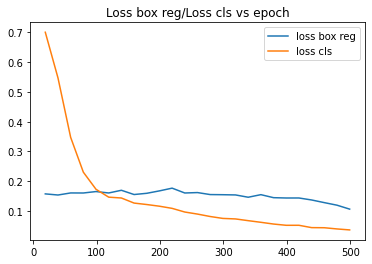

In [ ]:
#Solution here:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
#xVals = np.arange(0,df.shape[0])
xVals = df['iteration']
ax.set_title("Loss box reg/Loss cls vs epoch")
ax.plot(xVals, df['loss_box_reg']);
ax.plot(xVals, df['loss_cls']);
ax.legend(['loss box reg', 'loss cls'])

**Q5 Disscusion here**

The first plot showing the `loss_box_reg` metric shows the bounding box regression loss against the number of training epochs. This shows high close the bounding box is to the ground truth box.

The second plot showing the `loss_cls` metric shows the classification loss against the number of training epochs. This shows how whether there is any poor bounding boxes such as false negatives or positives.

## Q6) Test! (5)

Now that we have a trained model, we want to test its performance on unseen (*independent test*) data. A validation set and the required code to evaluate the model has been provided. We will use the detection evaluation metrics used by [COCO](https://cocodataset.org/#detection-eval) to evaluate our models. 

You must set a threshold for the classification confidence required to consider a detection as positive. You can test multiple thresholds to find the ideal one. 

**Questions:**
1. Run the cells below and the performance of your model on the validation set will be printed out. This will be a `dict` with the metric short-form name and th score. The ones that will be printed out are:

* Average Precision (AP):
  * AP: AP at IoU=.50:.05:.95 
  * AP50: AP at IoU=.50 
  * AP75: AP at IoU=.75
* AP Across Scales:
  * APs: AP for small objects
  * APm: AP for medium objects
  * APl: AP for large objects

2. Using the descriptions from [COCO](https://cocodataset.org/#detection-eval) describe what each type of AP represents.
3. Why do you think that the AP metric is lower when evaluated at IoU=0.75 compared to IoU=0.5?
4. The validation set was derived from the same dataset as the training set; if the test set contains images of babies that never appeared in the training data, how would the performance of your model compare on the test set?
5. Visualize any three examples of your model's detections over the `dataset_head`. You can make a prediction over an image by running `predictor(im)` which takes an image array as input.

In [ ]:
#@markdown Fill in this form with your parameter and run the cell.
threshold_score = 0.75 #@param {type: "number"}
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold_score

In [ ]:
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_head_val", output_dir="./output_head")
val_loader = build_detection_test_loader(cfg, "dataset_head_val")
val_results_head = inference_on_dataset(predictor.model, val_loader, evaluator)
print(val_results_head)

WARNING [04/18 04:20:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/18 04:20:49 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_head_val.json
[04/18 04:20:49 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    head    | 178          |
|            |              |
[04/18 04:20:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/18 04:20:49 d2.data.common]: Serializing 178 elements to byte tensors and concatenating them all ...
[04/18 04:20:49 d2.data.common]: Serialized dataset takes 0.05 MiB
[04/18 04:20:49 d2.evaluation.evaluator]: Start inference on 178 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/18 04:20:53 d2.evaluation.evaluator]: Inference done 11/178. Dataloading: 0.0019 s/iter. Inference: 0.3323 s/iter. Eval: 0.0003 s/iter. Total: 0.3345 s/iter. ETA=0:00:55
[04/18 04:20:58 d2.evaluation.evaluator]: Inference done 26/178. Dataloading: 0.0020 s/iter. Inference: 0.3332 s/iter. Eval: 0.0003 s/iter. Total: 0.3357 s/iter. ETA=0:00:51
[04/18 04:21:03 d2.evaluation.evaluator]: Inference done 41/178. Dataloading: 0.0021 s/iter. Inference: 0.3348 s/iter. Eval: 0.0003 s/iter. Total: 0.3374 s/iter. ETA=0:00:46
[04/18 04:21:08 d2.evaluation.evaluator]: Inference done 56/178. Dataloading: 0.0021 s/iter. Inference: 0.3352 s/iter. Eval: 0.0003 s/iter. Total: 0.3379 s/iter. ETA=0:00:41
[04/18 04:21:13 d2.evaluation.evaluator]: Inference done 71/178. Dataloading: 0.0021 s/iter. Inference: 0.3351 s/iter. Eval: 0.0003 s/iter. Total: 0.3378 s/iter. ETA=0:00:36
[04/18 04:21:18 d2.evaluation.evaluator]: Inference done 86/178. Dataloading: 0.0021 s/iter. Inference: 0.3352 s/iter. Eval: 0.000

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


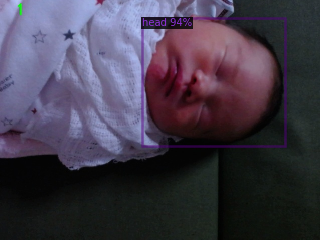

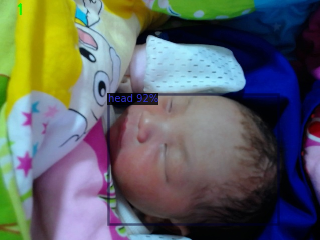

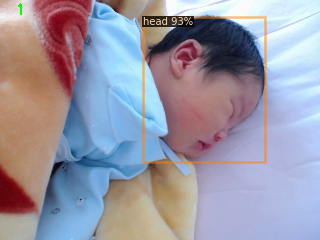

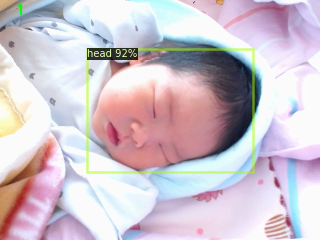

In [ ]:
for d in dataset_head[10:14]:    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_head, 
                   scale=0.5    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

**Q6 Discussion here**

AP is the mean average precision averaged over multiple IoU thresholds from 0.

50 to 0.95 in increments of 0.05. This is the primary challenge metric.

AP50 is the mAP with a threshold IoU of 0.50 which is the Pascal VOC metric.

AP75 is the mAP with a threshold IoU of 0.75 which is a strict metric.

APs is the mAP for small objects that covers area less than $32^2$

APm is the mAP for medium objects that covers between $32^2$ and $96^2$ of area

APl is the mAP for large objects that cover an area greater than $96^2$

When using a threshold IoU of 0.75, the AP metric is lower than the AP metric with a threshold IoU of 0.5 as reducing false positives with lower IoU increases the precision metric. Reducing the threshold IoU to 0.50 from 0.75 results in significant number of false positives, to a point where the images are covered in false positive bounding boxes that would not pass the 0.75 threshold.

If the training and test set contained overlapping data, the model would have better performance than as the model would be overfitted.

### Benchmark Predictions 

Now that you've evaluated your model on a validation set, it is time to use the test set. For this assignment, you are provided with a **blind** test set, where you do not know the actual annotations; instead you will submit your predictions that we will then use to evaluate your model against the gold-standard annotations. 

Run the cell below and when you submit your assignment, in addition to submitting your notebook, make sure to submit:


1.   `output_head/instances_predictions.pth` (file containing your predictions)
2.   `output_head/model_final.pth` (file containing your model weights, in case we need to re-run it)

You can download these files by going into **Files** tab, navigating to the proper folder, clicking on the three dots next to the file name and clicking download. 



In [ ]:
import torch
register_coco_instances("dataset_head_test_no_annotations", {}, "instances_head_test.json","Neonate Face Dataset")
evaluator = COCOEvaluator("dataset_head_test_no_annotations", output_dir="./output_head")
test_loader = torch.load('test_loader.pth')
test_results = inference_on_dataset(predictor.model, test_loader, evaluator)

## Q7) Face detection model (2)

Train and test a **face** detection model using the same configuration as the **head** detection model by running the code below. 

**Question:** Why do you you think there is a diffence in performance between this model compared to the head detection model?

In [ ]:
#Train
cfg.DATASETS.TRAIN = ("dataset_face_train")
cfg.OUTPUT_DIR = 'output_face'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
#Test
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_face_val", output_dir="./output_face")
val_loader = build_detection_test_loader(cfg, "dataset_face_val")
val_results_face = inference_on_dataset(predictor.model, val_loader, evaluator)
print(val_results_face)

[04/18 04:26:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/18 04:27:06 d2.utils.events]:  eta: 0:22:23  iter: 19  total_loss: 0.2263  loss_cls: 0.07937  loss_box_reg: 0.1139  loss_rpn_cls: 0.0167  loss_rpn_loc: 0.0117  time: 2.7001  data_time: 0.0460  lr: 7.7924e-06  max_mem: 7133M
[04/18 04:27:59 d2.utils.events]:  eta: 0:21:26  iter: 39  total_loss: 0.2155  loss_cls: 0.07187  loss_box_reg: 0.09623  loss_rpn_cls: 0.01973  loss_rpn_loc: 0.01275  time: 2.6832  data_time: 0.0291  lr: 1.5784e-05  max_mem: 7133M
[04/18 04:28:51 d2.utils.events]:  eta: 0:19:15  iter: 59  total_loss: 0.217  loss_cls: 0.07042  loss_box_reg: 0.1134  loss_rpn_cls: 0.009802  loss_rpn_loc: 0.01041  time: 2.6537  data_time: 0.0337  lr: 2.3776e-05  max_mem: 7133M
[04/18 04:29:45 d2.utils.events]:  eta: 0:19:29  iter: 79  total_loss: 0.1775  loss_cls: 0.06893  loss_box_reg: 0.08986  loss_rpn_cls: 0.01182  loss_rpn_loc: 0.01074  time: 2.6691  data_time: 0.0258  lr: 3.1768e-05  max_mem: 7133M
[04/18 04:30:39 d2.utils.events]:  eta: 0:18:03  iter: 99  total_loss: 0.2032  l

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


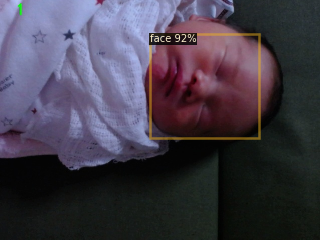

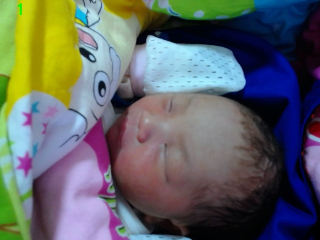

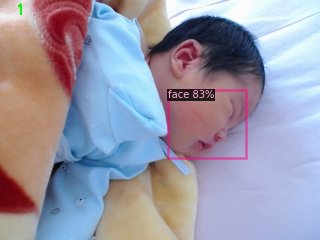

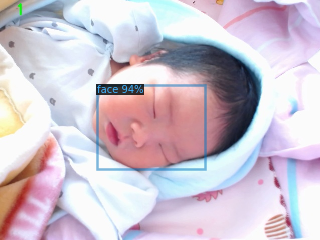

In [ ]:
for d in dataset_face[10:14]:    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_face, 
                   scale=0.5    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

**Q7 Discussion here**

Comparing the varing AP metrics for the head and face predictors, the face predictor had a significantly lower AP, AP75 and APl compared to the head predictor. AP50 was lower but not as significantly at 89.44 compared to 99.010. The other metrics for the face detector were roughly halved for AP and APl and AP75 was only 20% of the head predictor AP75. This could be because the boundary for a face is much harder to define in a large amount of the images as the face is not directly facing the camera. This is not significant for the head bounding box but could cause significant difficulty in detecting a face if the head is turned perpendicular to the camera angle and reduces the number of facial features being shown.

